# N225 Japan Index trading 

### Import dependecies 

In [1]:
import gym
import gym_anytrading
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum


from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import A2C
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

import pandas as pd
from matplotlib import pyplot as plt
from typing import Callable, Dict, List, Optional, Tuple, Type, Union

import torch as th
from torch import nn

from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

from finta import TA
from gym_anytrading.envs import StocksEnv


import os


### Data processing

In [2]:
df = pd.read_csv('data/N225.csv')

In [3]:
df.shape

(5711, 7)

In [4]:
df.dropna(inplace=True)
df['RSI'] = TA.RSI(df)
df['SMA'] = TA.SMA(df,14)
df['ATR'] = TA.ATR(df)
df.dropna(inplace=True)

### Creating my enviorment for AnyTrading, such that I can use 3 positions as actions (Short, Hold, Long) 

Here is the stanrd implementation of TradingEnv, I'm adding just the hold position

In [61]:
class Actions(Enum):
    Sell = 0
    Hold = 1
    Buy = 2


class Positions(Enum):
    Short = 0
    Hold = 1
    Long = 2
    

    def opposite(self):
        if self == Positions.Long:
            return Positions.Short
        else:
            return Positions.Long
        
        # elif self == Positions.Short:
            # return Positions.Long
        # return Positions.Hold


class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Hold
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
            # or
           # (action == Actions.Hold.value and self._position == Positions.Hold)
           ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            elif position == Positions.Hold:
                color = 'blue'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        hold_ticks = [] 
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
            elif self._position_history[i] == Positions.Hold:
                hold_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.plot(hold_ticks, self.prices[hold_ticks], 'bo')
        plt.plot(long_ticks, self.prices[long_ticks], 'go')

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        
        
    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

#### StocksEnv

Here I'm implementing StocksEnv such that it'll utilize Hold action also

In [72]:
# from .trading_env import TradingEnv, Actions, Positions


class StocksEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size)

        self.trade_fee_bid_percent = 0.003  # unit
        self.trade_fee_ask_percent = 0.003  # unit

    def _process_data(self):
        start = self.frame_bound[0] - self.window_size
        end = self.frame_bound[1]
        prices = self.df.loc[:,'Low'].to_numpy()[start:end]
        signal_features = self.df.loc[:,['Low','Volume','SMA','RSI','ATR']].to_numpy()[start:end]
        return prices, signal_features
    
#     def _process_data(self):
#         prices = self.df.loc[:, 'Close'].to_numpy()

#         prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
#         prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

#         diff = np.insert(np.diff(prices), 0, 0)
#         signal_features = np.column_stack((prices, diff))

#         return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Short.value and self._position == Positions.Long) 
            # or 
            # (action == Actions.Hold.value and self._position == Positions.Hold) 
           ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += price_diff
            elif self._position == Positions.Short:
                step_reward += -price_diff 

        return step_reward

    
# Is this actually correct? reutrn for short shuld be different I suppouse
    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long) 
            # or 
            # (action == Actions.Hold.value and self._position == Positions.Hold) 
           ):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price
            elif self._position == Positions.Short:
                self._total_profit = (self._total_profit *(1 + (last_trade_price - current_price - self.trade_fee_bid_percent*last_trade_price - self.trade_fee_ask_percent*current_price ) / last_trade_price))

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return 

In [68]:
env = StocksEnv(df=df,window_size = 9, frame_bound=(9,18))

info {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1}


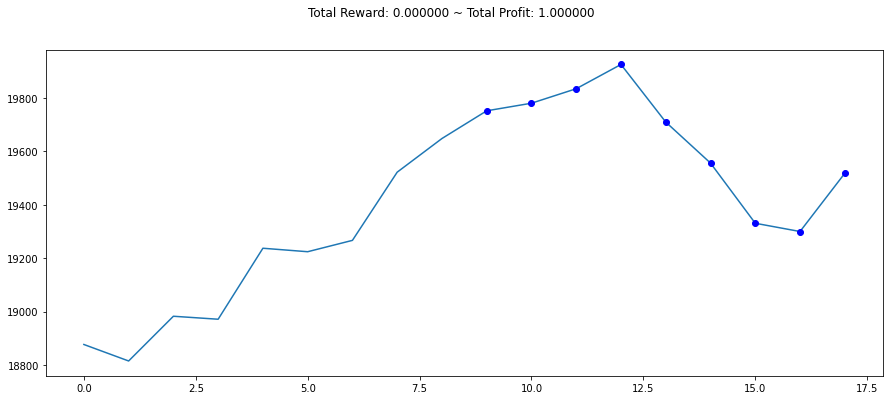

In [70]:
state = env.reset()
while True:
    # action = env.action_space.sample()
    action = 0
    n_state, reward,done, info = env.step(action)
    if done:
        print("info", info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [38]:
env.action_space.sample()

0